The goal of this notebook is to characterise the relationship between different weather markers and the duration of bike rides in the Austin bikeshare dataset. In order to do this, we will examine scatter plots between different variables and compute correlation statistics.

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import thinkplot
import thinkstats2

%matplotlib inline

# Read in bikeshare data

In [63]:
# read in data from a csv file
df = pd.read_csv('../Data/austin_bikeshare_trips.csv')

# Remove any trip with 0 minute duration
df = df[df['duration_minutes'] > 0]

# Reset the integer based index of the DataFrame
df.reset_index(drop=True, inplace=True)

greater_than_2_hours = df[df['duration_minutes'] > 120]
frac_of_dataset = 100 * len(greater_than_2_hours) / len(df)

# Remove any trip lasting longer than 2 hours
df = df[df['duration_minutes'] <= 120]

# Reset the integer based index of the DataFrame
df.reset_index(drop=True, inplace=True)

df['start_time'] = pd.to_datetime(df['start_time'])

df['date'] = df['start_time'].dt.date

# Read in weather data

In [59]:
# read in data from a csv file
weather_df = pd.read_csv('../Data/austin_weather.csv')

# Replace values with NaNs
weather_df.replace('-', np.nan, inplace=True)
weather_df.replace('T', np.nan, inplace=True)

# Convert column types to float
for col in weather_df:
    if col != 'Date' and col != 'Events':
        weather_df[[col]] = weather_df[[col]].astype(float)
        
# Convert the column type to the datetime type
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
# Set the index to that column
weather_df.index = weather_df['Date']

We've spent a fair amount of time examining the **duration_minutes** column within our dataset. Specifically, we've examined the CDF of this column by segmenting by day of the week. We saw that ridership is different between weekday and weekend rides.

However, we have reason to believe that the duration of a bike ride may also be affected by other variables. Specifically, the weather may have a large impact on the duration of a ride. Let's try to characterize this relationship.

First, let's characterize the relationship between temperature and duration. Let's look at a timeseries plot of the temperature and plot CDFs for duration by month.

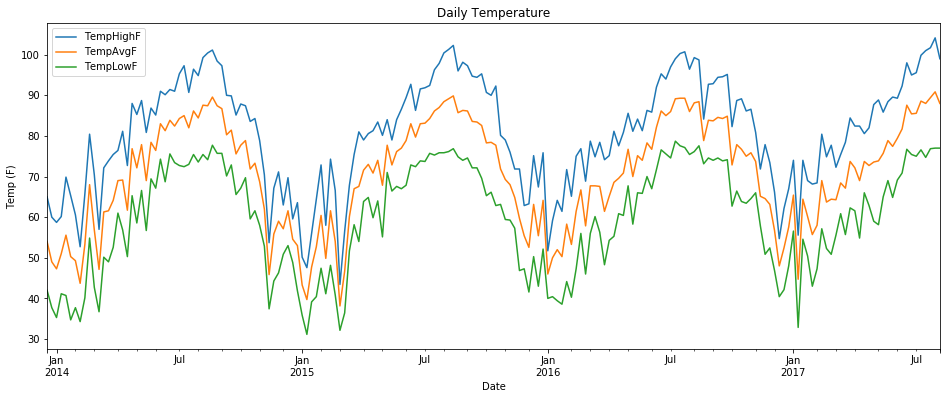

In [4]:
weather_df[['TempHighF', 'TempAvgF', 'TempLowF']].resample('W').mean().plot(
    title='Daily Temperature', figsize=(16, 6))

plt.ylabel('Temp (F)')
plt.show()

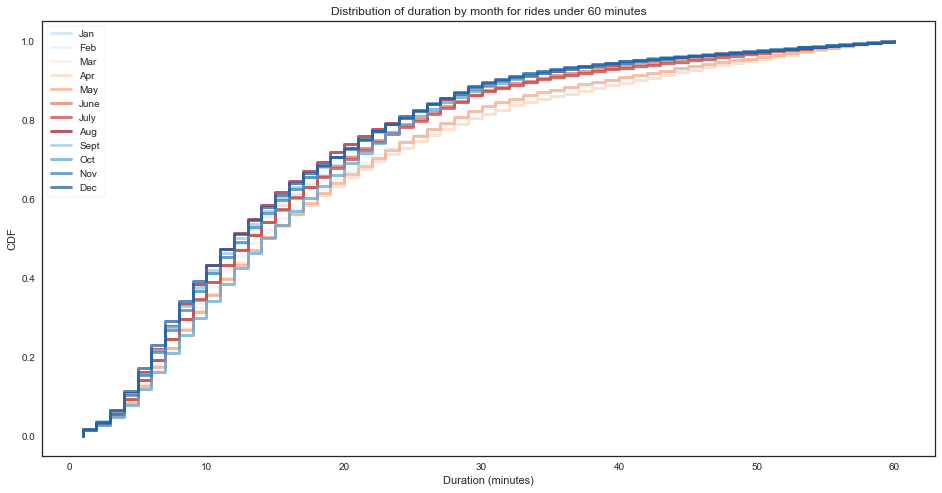

In [60]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July',
         'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

sub_60 = df[df['duration_minutes'] <= 60]

cdfs = [] 

for i in range(12):
    month_rides = sub_60[sub_60['month'] == i+1]
    cdf = thinkstats2.Cdf(month_rides['duration_minutes'], label=months[i])
    cdfs.append(cdf)
    
plt.figure(figsize=(16,8))
thinkplot.PrePlot(len(cdfs))
thinkplot.Cdfs(cdfs)
thinkplot.Config(title='Distribution of duration by month for rides under 60 minutes', 
                 xlabel='Duration (minutes)', ylabel='CDF')

If we segment the data by month of the year, we do see that the distribution of duration is different for different months. Notice that the CDFs for spring months are further to the right, signifying longer bike rides during those months. Rides are shorter during the coldest and warmest months of the year.

However, a scatterplot will serve us much better in visualizing the relationship between temperature and duration.

In [69]:
def get_merged_data(aggregation=None):
    """
    Return bikeshare data merged with weather data.
    
    aggregation: One of {None, 'mean', 'median'}
        Reduce the number of rows by performing some aggregation by day on the duration column.
    """
    if aggregation is None:
        _df = df[['date', 'duration_minutes']].copy()
        _df['date'] = pd.to_datetime(_df['date'])
        _df_weather = weather_df.copy()
        _df = _df.merge(_df_weather, how='left', left_on='date', right_on='Date')
    elif aggregation == 'mean':
        _df = df[['start_time', 'duration_minutes']].copy()
        _df.index = _df['start_time']
        _df = _df.resample('D').mean()
        _df = _df.join(weather_df)
    elif aggregation == 'median':
        _df = df[['start_time', 'duration_minutes']].copy()
        _df.index = _df['start_time']
        _df = _df.resample('D').median()
        _df = _df.join(weather_df)
    else:
        raise Error
        
    return _df

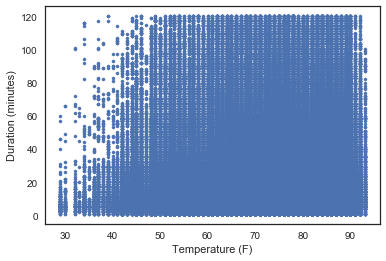

In [70]:
_df = get_merged_data()

plt.scatter(_df['TempAvgF'], _df['duration_minutes'], s=10)

plt.ylabel('Duration (minutes)')
plt.xlabel('Temperature (F)')

plt.show()

Clearly, this isn't a very good plot. One of the problems is that there is too much data to plot. We can use the methods discussed in the text to improve the plot.

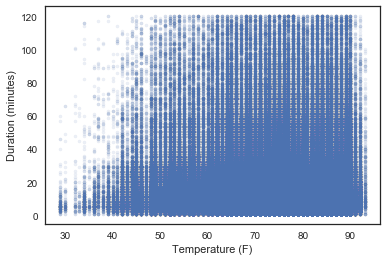

In [71]:
plt.scatter(_df['TempAvgF'], _df['duration_minutes'], s=10, alpha=.1)

plt.ylabel('Duration (minutes)')
plt.xlabel('Temperature (F)')

plt.show()

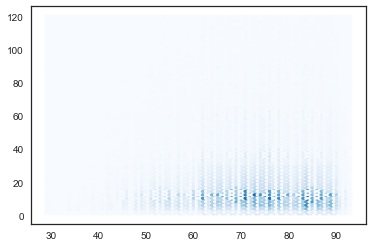

In [72]:
thinkplot.HexBin(_df['TempAvgF'], _df['duration_minutes'])

In our case, neither using transparency nor hex plots helped us out much. We can vary the parameters of the methods some more or look into the implementation of HexPlot to improve these, but we can use descriptive statistics to simplify this.

Rather than plot every single ride, we can resample our data by taking the mean bike ride duration of each day and scattering that against temperature.

In [73]:
sns.set()

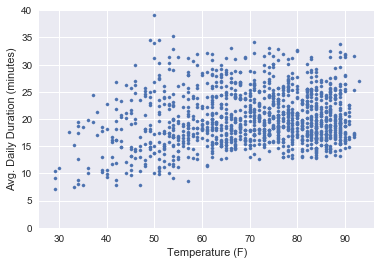

Pearson:                    TempAvgF  duration_minutes
TempAvgF          1.000000          0.163334
duration_minutes  0.163334          1.000000 

Spearman:                    TempAvgF  duration_minutes
TempAvgF           1.00000           0.11569
duration_minutes   0.11569           1.00000


In [75]:
_df = get_merged_data(aggregation='mean')

plt.scatter(_df['TempAvgF'], _df['duration_minutes'], s=10)

plt.ylabel('Avg. Daily Duration (minutes)')
plt.xlabel('Temperature (F)')

plt.ylim([0,40])

plt.show()

print('Pearson: ', _df[['TempAvgF', 'duration_minutes']].corr(), '\n')
print('Spearman: ', _df[['TempAvgF', 'duration_minutes']].corr(method='spearman'))

Much better. Of course, we've reduced the amount of information we can analyze by resampling, but we've also eliminated much of the noise and created a visualization that pulls out some meaningful information - a correlation between temperature and the average daily duration.

Notice that the avg. duration is lower on colder days. The correlation is positive, but not very large in magnitude (.16). From the plot, there seems to be a stronger correlation between temperature and avg. daily duration on days where the average temperature is less than 60 degrees.


We can also use the median to summarize our daily duration data rather than the mean.

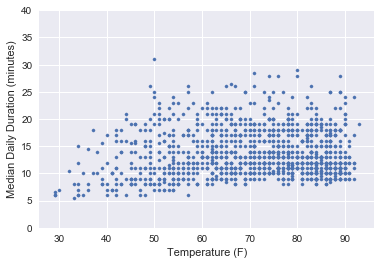

Pearson:                    TempAvgF  duration_minutes
TempAvgF          1.000000          0.092794
duration_minutes  0.092794          1.000000 

Spearman:                    TempAvgF  duration_minutes
TempAvgF          1.000000          0.063004
duration_minutes  0.063004          1.000000


In [77]:
_df = get_merged_data(aggregation='median')

plt.scatter(_df['TempAvgF'], _df['duration_minutes'], s=10)

plt.ylabel('Median Daily Duration (minutes)')
plt.xlabel('Temperature (F)')

plt.ylim([0,40])

plt.show()

print('Pearson: ', _df[['TempAvgF', 'duration_minutes']].corr(), '\n')
print('Spearman: ', _df[['TempAvgF', 'duration_minutes']].corr(method='spearman'))

Let's segment our data by looking at days where the temperature is above and below 60 degrees. 

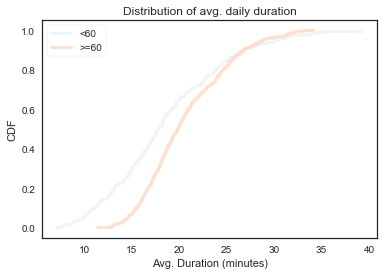

In [95]:
sns.set_style('white')

_df = get_merged_data(aggregation='mean')

sub_60_df = _df[_df['TempAvgF'] < 60]
greater_60_df = _df[_df['TempAvgF'] >= 60]

cdfs = [thinkstats2.Cdf(sub_60_df['duration_minutes'], label='<60'),
       thinkstats2.Cdf(greater_60_df['duration_minutes'], label='>=60')] 
    
thinkplot.PrePlot(len(cdfs))
thinkplot.Cdfs(cdfs)
thinkplot.Config(title='Distribution of avg. daily duration', 
                 xlabel='Avg. Duration (minutes)', ylabel='CDF')

From these CDFs we see that trips are typically much shorter on days where the temperature is less than 60 degrees. Let's focus on these points in our scatter plot.

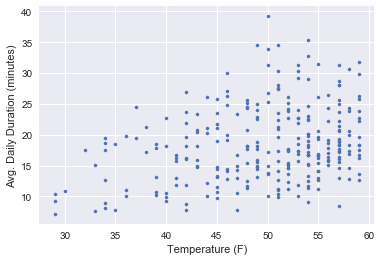

Pearson:                    TempAvgF  duration_minutes
TempAvgF          1.000000          0.294665
duration_minutes  0.294665          1.000000 

Spearman:                    TempAvgF  duration_minutes
TempAvgF          1.000000          0.253935
duration_minutes  0.253935          1.000000


In [96]:
sns.set()

plt.scatter(sub_60_df['TempAvgF'], sub_60_df['duration_minutes'], s=10)

plt.ylabel('Avg. Daily Duration (minutes)')
plt.xlabel('Temperature (F)')

plt.show()

print('Pearson: ', sub_60_df[['TempAvgF', 'duration_minutes']].corr(), '\n')
print('Spearman: ', sub_60_df[['TempAvgF', 'duration_minutes']].corr(method='spearman'))

Although the correlation is not very high - about 0.3 - the correlation is higher than if we include all temperatures. This confirms our earlier claim that there is a stronger correlation when the temperature is less than 60 degrees.
However, this is not a very strong linear relationship.

Let's examine the effect of other weather variables on the duration column.

## What effect does Humidity have on duration?

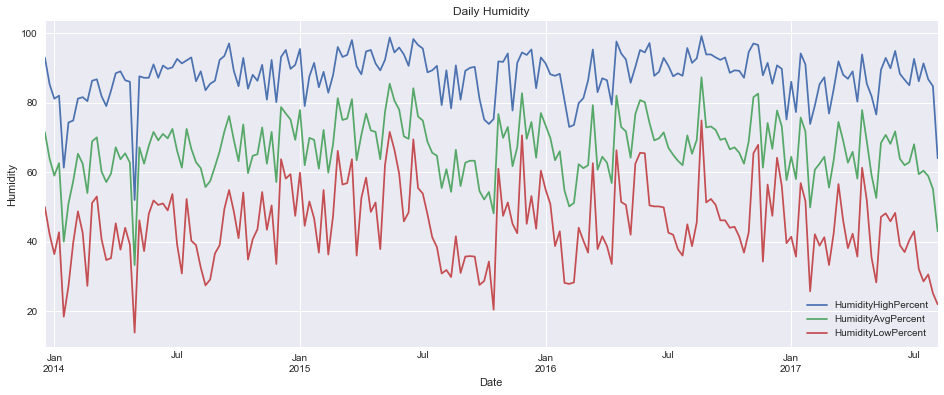

In [97]:
weather_df[['HumidityHighPercent', 'HumidityAvgPercent', 'HumidityLowPercent']].resample('W').mean().plot(
    title='Daily Humidity', figsize=(16, 6))

plt.ylabel('Humidity')
plt.show()

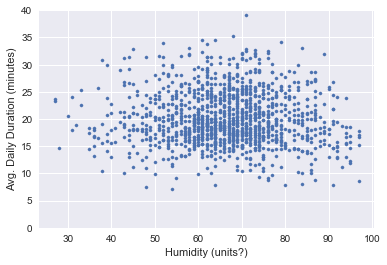

Pearson:                      HumidityAvgPercent  duration_minutes
HumidityAvgPercent            1.000000         -0.044935
duration_minutes             -0.044935          1.000000 

Spearman:                      HumidityAvgPercent  duration_minutes
HumidityAvgPercent            1.000000         -0.033208
duration_minutes             -0.033208          1.000000


In [98]:
_df = get_merged_data(aggregation='mean')

plt.scatter(_df['HumidityAvgPercent'], _df['duration_minutes'], s=10)

plt.ylabel('Avg. Daily Duration (minutes)')
plt.xlabel('Humidity (units?)')

plt.ylim([0,40])

plt.show()

print('Pearson: ', _df[['HumidityAvgPercent', 'duration_minutes']].corr(), '\n')
print('Spearman: ', _df[['HumidityAvgPercent', 'duration_minutes']].corr(method='spearman'))

## What effect does visibility have on duration?

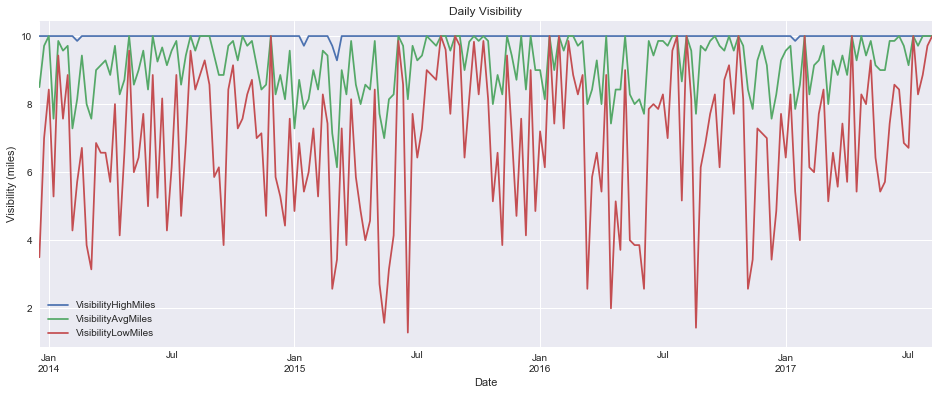

In [99]:
weather_df[['VisibilityHighMiles', 'VisibilityAvgMiles', 'VisibilityLowMiles']].resample('W').mean().plot(
    title='Daily Visibility', figsize=(16, 6))

plt.ylabel('Visibility (miles)')
plt.show()

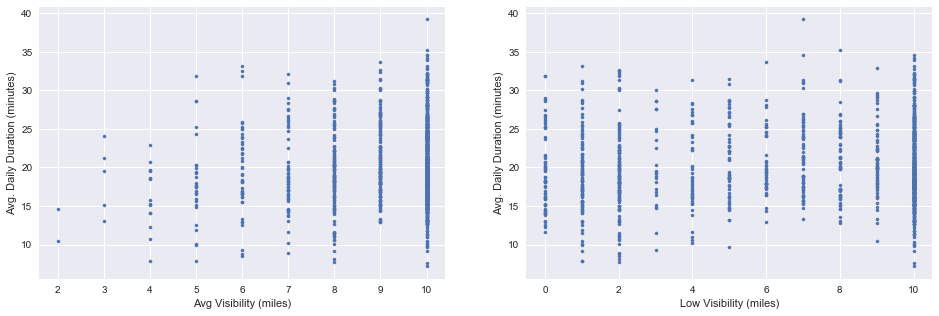

Average
Pearson:                      VisibilityAvgMiles  duration_minutes
VisibilityAvgMiles            1.000000          0.120896
duration_minutes              0.120896          1.000000 

Spearman:                      VisibilityAvgMiles  duration_minutes
VisibilityAvgMiles            1.000000          0.078662
duration_minutes              0.078662          1.000000 

Low
Pearson:                      VisibilityLowMiles  duration_minutes
VisibilityLowMiles            1.000000          0.070379
duration_minutes              0.070379          1.000000 

Spearman:                      VisibilityLowMiles  duration_minutes
VisibilityLowMiles            1.000000          0.048989
duration_minutes              0.048989          1.000000


In [102]:
_df = get_merged_data(aggregation='mean')

plt.figure(figsize=(16,5))

plt.subplot(121)
plt.scatter(_df['VisibilityAvgMiles'], _df['duration_minutes'], s=10)
plt.ylabel('Avg. Daily Duration (minutes)')
plt.xlabel('Avg Visibility (miles)')

plt.subplot(122)
plt.scatter(_df['VisibilityLowMiles'], _df['duration_minutes'], s=10)
plt.ylabel('Avg. Daily Duration (minutes)')
plt.xlabel('Low Visibility (miles)')

plt.show()

print('Average')
print('Pearson: ', _df[['VisibilityAvgMiles', 'duration_minutes']].corr(), '\n')
print('Spearman: ', _df[['VisibilityAvgMiles', 'duration_minutes']].corr(method='spearman'), '\n')

print('Low')
print('Pearson: ', _df[['VisibilityLowMiles', 'duration_minutes']].corr(), '\n')
print('Spearman: ', _df[['VisibilityLowMiles', 'duration_minutes']].corr(method='spearman'))

## What effect does precipitation have on duration?

### Looking at all the data

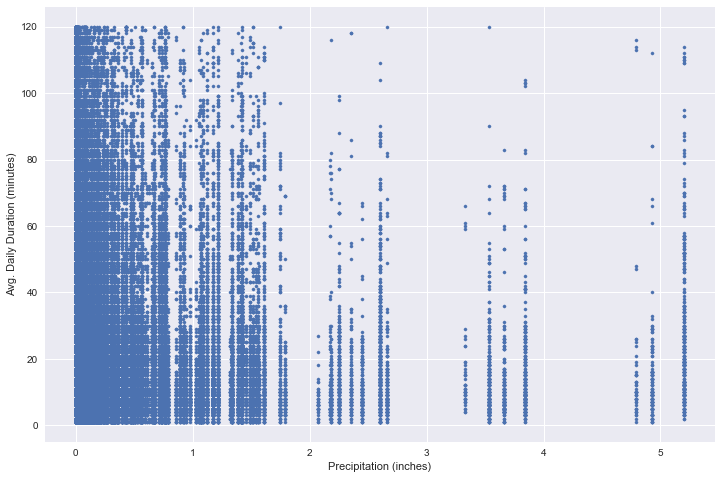

Pearson:                          PrecipitationSumInches  duration_minutes
PrecipitationSumInches                1.000000         -0.007529
duration_minutes                     -0.007529          1.000000 

Spearman:                          PrecipitationSumInches  duration_minutes
PrecipitationSumInches                1.000000         -0.004703
duration_minutes                     -0.004703          1.000000


In [103]:
_df = get_merged_data()

plt.figure(figsize=(12,8))

plt.scatter(_df['PrecipitationSumInches'], _df['duration_minutes'], s=10)

plt.ylabel('Avg. Daily Duration (minutes)')
plt.xlabel('Precipitation (inches)')

plt.show()

print('Pearson: ', _df[['PrecipitationSumInches', 'duration_minutes']].corr(), '\n')
print('Spearman: ', _df[['PrecipitationSumInches', 'duration_minutes']].corr(method='spearman'))

### Looking at just the daily mean

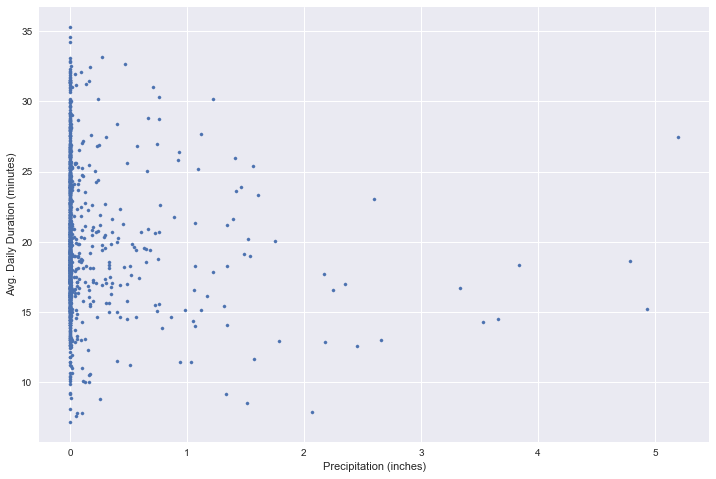

Pearson:                          PrecipitationSumInches  duration_minutes
PrecipitationSumInches                1.000000         -0.082092
duration_minutes                     -0.082092          1.000000 

Spearman:                          PrecipitationSumInches  duration_minutes
PrecipitationSumInches                1.000000         -0.084481
duration_minutes                     -0.084481          1.000000


In [106]:
_df = get_merged_data(aggregation='mean')

plt.figure(figsize=(12,8))

plt.scatter(_df['PrecipitationSumInches'], _df['duration_minutes'], s=10)

plt.ylabel('Avg. Daily Duration (minutes)')
plt.xlabel('Precipitation (inches)')

plt.show()

print('Pearson: ', _df[['PrecipitationSumInches', 'duration_minutes']].corr(), '\n')
print('Spearman: ', _df[['PrecipitationSumInches', 'duration_minutes']].corr(method='spearman'))